Key Components

1. StateGraph: The core of our application, defining flow of our Travel Planner.
2. PlannerState: A custom type representing the state of our planning process.
3. Node functions: Individual steps in our planning process (input_city, input_interesets, create_itinerary).
4. LLM Integration: Utilizing a language model to generate the final itinerary.

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

Define Agent


In [ ]:
class PlannerState(TypedDict):
  messages: Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature= 0,
    groq_api_key= "api_key",
    model_name= "llama-3.3-70b-versatile"
)

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Define the template with placeholders
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip.")
])

# Fill in the variables (later when you're ready to use it)
filled_prompt = itinerary_prompt.format_messages(city="Paris", interests="art, history, and local cuisine")


Define Agent Function


In [ ]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_messages = input("Your Input: ")
  return {
      **state,
      "city": user_messages,
      "messages": state["messages"] + [HumanMessage(content=user_messages)]
  }
def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-sparated)")
  user_messages = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_messages.split(",")],
      "messages": state["messages"] + [HumanMessage(content=user_messages)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interest : {','.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city=state["city"], interests=",".join(state["interests"])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary": response.content
  }

Create and compile the graph

In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

Display the graph structure

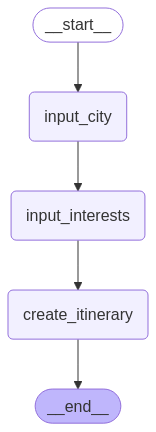

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method  = MermaidDrawMethod.API
        )
    )
)

define the function thats run the graph

In [ ]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": ""
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: Delhi
Please enter your interest for the trip to : Delhi (comma-sparated)
Your Input: Kutub Minar, Chandni Chowk, Maujpur
Creating an itinerary for Delhi based on interest : Kutub Minar,Chandni Chowk,Maujpur

Final Itinerary: 
Here's a brief, bulleted itinerary for your day trip to Delhi based on your interests:

* 9:00 AM: Start the day with a visit to Qutub Minar, a UNESCO World Heritage Site and one of the tallest minarets in India.
* 11:30 AM: Head to Chandni Chowk, one of the oldest and busiest markets in Delhi, to explore its narrow streets, try some street food, and shop for souvenirs.
* 2:30 PM: Take a break for lunch at a local restaurant in Chandni Chowk, trying some popular Delhi dishes like chaat, kebabs, or biryani.
* 4:00 PM: Visit Maujpur, a lesser-known area in Delhi, to explore its local culture, visit the Maujpur Sabzi Mandi (vegetable market), and see t

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

class PlannerState(TypedDict):
  messages: Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

llm = ChatGroq(
    temperature= 0,
    groq_api_key= "api_key",
    model_name= "llama-3.3-70b-versatile"
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip.")
])

# Fill in the variables (later when you're ready to use it)
filled_prompt = itinerary_prompt.format_messages(city="Paris", interests="art, history, and local cuisine")

def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_messages = input("Your Input: ")
  return {
      **state,
      "city": user_messages,
      "messages": state["messages"] + [HumanMessage(content=user_messages)]
  }
def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-sparated)")
  user_messages = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_messages.split(",")],
      "messages": state["messages"] + [HumanMessage(content=user_messages)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interest : {','.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city=state["city"], interests=",".join(state["interests"])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary": response.content
  }


def travel_planner(city: str, interests: str):
  state = {
      "messages": [],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  state = input_city(city, state)
  state = input_interest(interests, state)

  state = create_itinerary(state)

interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="EnInitial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip:
Your Input: Delhi

---------------------------------------------------------------------------

KeyError                                  Traceback (most recent call last)

<ipython-input-10-09874d4f5a42> in <cell line: 0>()
      1 user_request = "I want to plan a day trip"
----> 2 travel_planner(user_request)

2 frames

<ipython-input-9-1de3e2b7038e> in travel_planner(user_request)
      7       "itinerary": ""
      8   }
----> 9   for output in app.stream(state):
     10     pass

/usr/local/lib/python3.11/dist-packages/langgraph/pregel/__init__.py in stream(self, input, config, stream_mode, output_keys, interrupt_before, interrupt_after, checkpoint_during, debug, subgraphs)
   2459                 # with channel updates applied only at the transition between steps.
   2460                 while loop.tick(input_keys=self.input_channels):
-> 2461                     for _ in runner.tick(
   2462                         loop.tasks.values(),
   2463                         timeout=self.step_timeout,

<ipython-input-6-5b97dfaa11c5> in input_city(state)
      5       **state,
      6       "city": user_messages,
----> 7       "messages": state["messages"] + [HumanMessage(content=user_messages)]
      8   }
      9 def input_interest(state: PlannerState) -> PlannerState:

KeyError: 'messages'

ter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

interface.launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.0.1.json:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1677859952771dcd93.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
